<a href="https://colab.research.google.com/github/nlavee/slt-cs230/blob/main/TF_Seq2Seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Seq2Seq for Translation

This colab performs simple data processing and set up Seq2Seq for Translation using Datasets for SLT project (CS230).

Code is adapted from [Seq2Seq for Translation Tutorial](https://www.tensorflow.org/addons/tutorials/networks_seq2seq_nmt).

## Data
The easiest way to get the data for this colab is to download `data/` folder from [Github](https://github.com/nlavee/slt-cs230/tree/main/data), and upload them to the env of colab. Note that each time the colab instance is down, all data will be wiped, so you'll have to reupload them. 

*(Another way to do this is through GitHub API, which unfortunately prevents reading files larger than 1MB).*


anhvu.nguyenlam@gmail.com

## **TODO for the team:**

[For next week]
1. Read through original [Github page](https://github.com/kayoyin/transformer-slt) to understand pytorch implementation. Priorities: 
    0. [Data preprocessing](https://github.com/kayoyin/transformer-slt#data-processing). Whether OpenNMT has a TF counterpart? [All will check to see what this do?]
    1. rnn with attention model with encoder / decoder. [Ben will check this part] 
    2. transformer. [El will check on this part]
2. Understand this colab to see how much we've gotten from tensorflow implementation.
   * Improve data ingestion for this colab [Vu will check on this]
   * Define metrics that we care about in this colab as well.  [Vu will check on this]

[After next week]
3. Try to replicate the same architecture in pytorch over to tf. Priorities: 1) rnn with attention 2) transformer.
4. Look into making the model run with fewer resources available

[Interim]
5. Look into SLR models that we can use to plug into image --> gloss to get input for this particular model. Do this when we can :)


## What we want to do with the project?
* Improve models, add features, technique (regularization, etc)
* Quantization of models to run on edge devices
* (Think about this...)

## Midterms prep:
* Let's do winter 2020 together next week
* Do the previous years by yourself first to prep to that 2020.

In [20]:
pip install tensorflow-addons==0.11.2

In [21]:
#@title Import / Setup
import pandas as pd
import re
from _collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_addons as tfa
import unicodedata
import numpy as np
import os
import io
import time

In [22]:
#@title Looking at the Train ASLG EN dataset.

train_en_dataset_path = "aslg.train.en" #@param {type: "string", is_template: true}
train_gloss_dataset_path = "aslg.train.gloss.asl" #@param {type: "string", is_template: true}
# f = open(train_dataset_path, "r")

In [23]:
class NMTDataset:
  def __init__(self, problem_type="gloss-en"):
    self.problem_type = problem_type
    self.inp_lang_tokenizer = None
    self.targ_lang_tokenizer = None

  def unicode_to_ascii(self, s):
    return ''.join (c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c))
  
  ## 1) Add a start and end token to each sentence.
  ## 2) Clean the sentences by removing special characters.
  def preprocess_sentence(self, w):
    w = self.unicode_to_ascii(w.lower().strip())

    # creating a space between a word and the punctuation following it
    # e.g.: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",", "-")
    w = re.sub(r"[^a-zA-Z?.!\-,¿]+", " ", w)

    w = w.strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    # print(f"Processed Sentence: {w}")
    return w
  
  def create_dataset(self, paths, num_examples):
    (train_en_set_path, train_gloss_set_path) = paths

    train_en_lines = io.open(train_en_set_path, encoding='UTF-8').read().strip().split('\n')
    train_gloss_lines = io.open(train_gloss_set_path, encoding='UTF-8').read().strip().split('\n')
    
    word_pairs = []
    for i in range(0, num_examples):
      inp = train_gloss_lines[i]
      targ = train_en_lines[i]
      # print(f"Input: {inp} - Target: {targ}")
      word_pairs.append(
          [self.preprocess_sentence(inp), 
           self.preprocess_sentence(targ)])
      
    return zip(*word_pairs)
  
  ## 3) Create a vocabulary with word index (mapping from word -> id) and reverse word index (mapping from id -> word)
  ## 4) Pad each sentence to a maximum length.
  def tokenize(self, lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', oov_token='<OOV>')
    lang_tokenizer.fit_on_texts(lang)

    ## tf.keras.preprocessing.text.Tokenizer.texts_to_sequences converts string (w1, w2, w3, ......, wn) 
    ## to a list of correspoding integer ids of words (id_w1, id_w2, id_w3, ...., id_wn)
    tensor = lang_tokenizer.texts_to_sequences(lang) 
    print(f"Tensor of sequences from texts: {tensor}")

    ## tf.keras.preprocessing.sequence.pad_sequences takes argument a list of integer id sequences
    ## and pads the sequences (at the end) to match the longest sequences in the given input.
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, lang_tokenizer
  
  def load_dataset(self, paths, num_examples=None):
    # creating cleaned input, output pairs.
    targ_lang, inp_lang = self.create_dataset(paths, num_examples)

    input_tensor, inp_lang_tokenizer = self.tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = self.tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer
  
  def call(self, num_examples, BUFFER_SIZE, BATCH_SIZE):    
    input_tensor, target_tensor, self.inp_lang_tokenizer, self.targ_lang_tokenizer = self.load_dataset(
        (train_en_dataset_path, train_gloss_dataset_path), 
        num_examples)

    # Can skip this test since we have dedicated test set.
    input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(
        input_tensor, 
        target_tensor, 
        test_size = 0.2)

    train_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train))
    train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

    val_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_val, target_tensor_val))
    val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder = True)

    return train_dataset, val_dataset, self.inp_lang_tokenizer, self.targ_lang_tokenizer




In [24]:
BUFFER_SIZE = 32000 #@param {is_template:true}
BATCH_SIZE = 64 #@param {is_template:true}
# Let's limit the #training examples for faster training
num_examples = 1024 #@param {is_template:true}

dataset_creator = NMTDataset('gloss-en')
train_dataset, val_dataset, inp_lang, targ_lang = dataset_creator.call(num_examples, BUFFER_SIZE, BATCH_SIZE)

Tensor of sequences from texts: [[2, 23, 4, 24, 6, 5, 3], [2, 28, 4, 5, 4, 29, 10, 6, 5, 3], [2, 23, 4, 24, 6, 5, 3], [2, 147, 4, 148, 6, 5, 3], [2, 27, 32, 6, 5, 3], [2, 30, 40, 11, 78, 79, 55, 6, 5, 3], [2, 101, 6, 5, 3], [2, 42, 4, 69, 70, 41, 7, 45, 6, 5, 3], [2, 63, 83, 19, 24, 56, 71, 6, 5, 3], [2, 31, 13, 22, 10, 6, 5, 3], [2, 33, 4, 10, 3], [2, 7, 10, 16, 34, 14, 8, 17, 8, 15, 8, 3], [2, 210, 4, 267, 178, 4, 7, 25, 24, 108, 13, 268, 211, 6, 5, 3], [2, 7, 10, 16, 35, 14, 8, 17, 8, 15, 8, 11, 43, 14, 8, 17, 8, 15, 8, 3], [2, 210, 4, 407, 4, 7, 25, 24, 108, 13, 268, 211, 6, 5, 3], [2, 7, 10, 16, 35, 14, 8, 17, 8, 15, 8, 11, 43, 14, 8, 17, 8, 15, 8, 3], [2, 31, 13, 22, 10, 6, 5, 3], [2, 33, 4, 10, 3], [2, 7, 10, 16, 34, 14, 8, 17, 8, 15, 8, 3], [2, 49, 4, 7, 10, 3], [2, 7, 10, 16, 53, 14, 8, 18, 8, 15, 8, 3], [2, 27, 32, 6, 5, 3], [2, 28, 4, 5, 4, 29, 10, 6, 5, 3], [2, 23, 4, 24, 6, 5, 3], [2, 23, 4, 44, 108, 13, 55, 122, 6, 5, 3], [2, 7, 10, 16, 35, 14, 17, 8, 15, 8, 11, 43, 14, 1

In [25]:
example_input_batch, example_target_batch = next(iter(train_dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 20]), TensorShape([64, 19]))

In [26]:
# Important parameters
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1
max_length_input = example_input_batch.shape[1]
max_length_output = example_target_batch.shape[1]
print(
    f"vocab_inp_size (gloss): {vocab_inp_size}\n" + 
    f"vocab_tar_size (en): {vocab_tar_size}\n" + 
    f"max_length_input (gloss): {max_length_input}\n" + 
    f"max_length_output (en): {max_length_output}\n"
)

embedding_dim = 256 #@param {is_template:true}
units = 1024 #@param {is_template:true}
steps_per_epoch = num_examples//BATCH_SIZE

vocab_inp_size (gloss): 1063
vocab_tar_size (en): 990
max_length_input (gloss): 20
max_length_output (en): 19



In [27]:
##### Encoder Class

class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)

    ##________ LSTM layer in Encoder ------- ##
    self.lstm_layer = tf.keras.layers.LSTM(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')



  def call(self, x, hidden):
    x = self.embedding(x)
    # output: whole_seq_output, final_memory_state, final_carry_stat
    output, h, c = self.lstm_layer(x, initial_state = hidden)
    return output, h, c

  def initialize_hidden_state(self):
    return [tf.zeros((self.batch_sz, self.enc_units)), tf.zeros((self.batch_sz, self.enc_units))]

In [28]:
## Test Encoder Stack

encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)


# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_h, sample_c = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder h vector shape: (batch size, units) {}'.format(sample_h.shape))
print ('Encoder c vector shape: (batch size, units) {}'.format(sample_c.shape))

Encoder output shape: (batch size, sequence length, units) (64, 20, 1024)
Encoder h vector shape: (batch size, units) (64, 1024)
Encoder c vector shape: (batch size, units) (64, 1024)


In [29]:
##### Decoder Class.
class Decoder(tf.keras.Model):
  def __init__(self, 
               vocab_size, 
               embedding_dim, 
               dec_units, 
               batch_sz, 
               attention_type='luong'):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.attention_type = attention_type

    # Embedding Layer
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)

    #Final Dense layer on which softmax will be applied
    self.fc = tf.keras.layers.Dense(vocab_size)

    # Define the fundamental cell for decoder recurrent structure
    self.decoder_rnn_cell = tf.keras.layers.LSTMCell(self.dec_units)

    # Sampler
    self.sampler = tfa.seq2seq.sampler.TrainingSampler()

    # Create attention mechanism with memory = None
    self.attention_mechanism = self.build_attention_mechanism(self.dec_units, 
                                                              None, 
                                                              self.batch_sz*[max_length_input], 
                                                              self.attention_type)

    # Wrap attention mechanism with the fundamental rnn cell of decoder
    self.rnn_cell = self.build_rnn_cell(batch_sz)

    # Define the decoder with respect to fundamental rnn cell
    self.decoder = tfa.seq2seq.BasicDecoder(self.rnn_cell, sampler=self.sampler, output_layer=self.fc)


  def build_rnn_cell(self, batch_sz):
    rnn_cell = tfa.seq2seq.AttentionWrapper(self.decoder_rnn_cell, 
                                  self.attention_mechanism, attention_layer_size=self.dec_units)
    return rnn_cell

  def build_attention_mechanism(self, 
                                dec_units, 
                                memory, 
                                memory_sequence_length, 
                                attention_type='luong'):
    # ------------- #
    # attention_type: Which sort of attention (Bahdanau, Luong)
    # dec_units: final dimension of attention outputs 
    # memory: encoder hidden states of shape (batch_size, max_length_input, enc_units)
    # memory_sequence_length: 1d array of shape (batch_size) with every element set to max_length_input (for masking purpose)

    if(attention_type=='bahdanau'):
      return tfa.seq2seq.BahdanauAttention(units=dec_units, memory=memory, memory_sequence_length=memory_sequence_length)
    else:
      return tfa.seq2seq.LuongAttention(units=dec_units, memory=memory, memory_sequence_length=memory_sequence_length)

  def build_initial_state(self, batch_sz, encoder_state, Dtype):
    decoder_initial_state = self.rnn_cell.get_initial_state(batch_size=batch_sz, dtype=Dtype)
    decoder_initial_state = decoder_initial_state.clone(cell_state=encoder_state)
    return decoder_initial_state


  def call(self, inputs, initial_state):
    x = self.embedding(inputs)
    outputs, _, _ = self.decoder(x, initial_state=initial_state, sequence_length=self.batch_sz*[max_length_output-1])
    return outputs

In [30]:
# Test decoder stack

decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE, 'luong')
sample_x = tf.random.uniform((BATCH_SIZE, max_length_output))
decoder.attention_mechanism.setup_memory(sample_output)
initial_state = decoder.build_initial_state(BATCH_SIZE, [sample_h, sample_c], tf.float32)


sample_decoder_outputs = decoder(sample_x, initial_state)

print("Decoder Outputs Shape: ", sample_decoder_outputs.rnn_output.shape)

Decoder Outputs Shape:  (64, 18, 990)


In [49]:
# Optimizer and loss function
learning_rate = 0.01 #@param
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

def loss_function(real, pred):
  # real shape = (BATCH_SIZE, max_length_output)
  # pred shape = (BATCH_SIZE, max_length_output, tar_vocab_size )
  cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
  loss = cross_entropy(y_true=real, y_pred=pred)
  mask = tf.logical_not(tf.math.equal(real,0))   #output 0 for y=0 else output 1
  mask = tf.cast(mask, dtype=loss.dtype)  
  loss = mask * loss
  loss = tf.reduce_mean(loss)
  return loss

In [50]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [51]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_h, enc_c = encoder(inp, enc_hidden)

    dec_input = targ[ : , :-1 ] # Ignore <end> token
    real = targ[ : , 1: ]         # ignore <start> token

    # Set the AttentionMechanism object with encoder_outputs
    decoder.attention_mechanism.setup_memory(enc_output)

    # Create AttentionWrapperState as initial_state for decoder
    decoder_initial_state = decoder.build_initial_state(BATCH_SIZE, [enc_h, enc_c], tf.float32)
    pred = decoder(dec_input, decoder_initial_state)
    logits = pred.rnn_output
    loss = loss_function(real, logits)

  variables = encoder.trainable_variables + decoder.trainable_variables
  # Note: Gradient Tape before applying: 
  # https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Optimizer#processing_gradients_before_applying_them_2
  gradients = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(gradients, variables))

  return loss

(64, 1024) (64, 1024)
Epoch 1 Batch 0 Loss 882.4099
Epoch 1 Loss 1178.2118
Time taken for 1 epoch 3.8326737880706787 sec

(64, 1024) (64, 1024)
Epoch 2 Batch 0 Loss 1465.7300
Epoch 2 Loss 1009.0881
Time taken for 1 epoch 1.0018177032470703 sec

(64, 1024) (64, 1024)
Epoch 3 Batch 0 Loss 1270.9106
Epoch 3 Loss 894.0765
Time taken for 1 epoch 0.9962599277496338 sec

(64, 1024) (64, 1024)
Epoch 4 Batch 0 Loss 1076.4956
Epoch 4 Loss 778.0656
Time taken for 1 epoch 1.0176496505737305 sec

(64, 1024) (64, 1024)
Epoch 5 Batch 0 Loss 1100.9568
Epoch 5 Loss 711.2654
Time taken for 1 epoch 0.9853062629699707 sec

(64, 1024) (64, 1024)
Epoch 6 Batch 0 Loss 1057.4821
Epoch 6 Loss 703.8607
Time taken for 1 epoch 1.0383241176605225 sec

(64, 1024) (64, 1024)
Epoch 7 Batch 0 Loss 702.3425
Epoch 7 Loss 692.0081
Time taken for 1 epoch 1.0266518592834473 sec

(64, 1024) (64, 1024)
Epoch 8 Batch 0 Loss 842.2034
Epoch 8 Loss 757.6068
Time taken for 1 epoch 0.9859058856964111 sec

(64, 1024) (64, 1024)
Epo

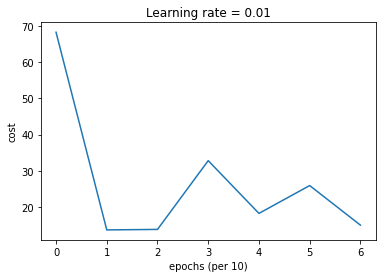

In [52]:
EPOCHS = 70 #@param

costs = []
for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0
  print(enc_hidden[0].shape, enc_hidden[1].shape)

  for (batch, (inp, targ)) in enumerate(train_dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 10 epochs
  if (epoch + 1) % 10 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)
    costs.append(batch_loss / len(inp))

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

  # plot the cost
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('epochs (per 10)')
plt.title("Learning rate = " + str(learning_rate))
plt.show()

In [53]:
def evaluate_sentence(sentence):
  # preprocess the sentence and turn into tensor after splitting words.
  sentence = dataset_creator.preprocess_sentence(sentence)
  print(f"Input sentence: {sentence}")
  # print(inp_lang.word_index)

  # if word is in tokenizer, then use it, otherwise use 1 for OOV.
  inputs = [inp_lang.word_index[i] if i in inp_lang.word_index else 1 for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                          maxlen=max_length_input,
                                                          padding='post')
  inputs = tf.convert_to_tensor(inputs)
  inference_batch_size = inputs.shape[0]
  result = ''

  # send to encoder to get a representation.
  enc_start_state = [tf.zeros((inference_batch_size, units)), tf.zeros((inference_batch_size,units))]
  enc_out, enc_h, enc_c = encoder(inputs, enc_start_state)

  dec_h = enc_h
  dec_c = enc_c

  start_tokens = tf.fill([inference_batch_size], targ_lang.word_index['<start>'])
  end_token = targ_lang.word_index['<end>']

  greedy_sampler = tfa.seq2seq.GreedyEmbeddingSampler()

  # Instantiate BasicDecoder object
  decoder_instance = tfa.seq2seq.BasicDecoder(
      cell=decoder.rnn_cell, 
      sampler=greedy_sampler, 
      output_layer=decoder.fc)
  # Setup Memory in decoder stack
  decoder.attention_mechanism.setup_memory(enc_out)

  # set decoder_initial_state
  decoder_initial_state = decoder.build_initial_state(inference_batch_size, [enc_h, enc_c], tf.float32)

  ### Since the BasicDecoder wraps around Decoder's rnn cell only, you have to ensure that the inputs to BasicDecoder 
  ### decoding step is output of embedding layer. tfa.seq2seq.GreedyEmbeddingSampler() takes care of this. 
  ### You only need to get the weights of embedding layer, which can be done by decoder.embedding.variables[0] and pass this callabble to BasicDecoder's call() function

  decoder_embedding_matrix = decoder.embedding.variables[0]

  outputs, _, _ = decoder_instance(
      decoder_embedding_matrix, 
      start_tokens = start_tokens, 
      end_token= end_token, 
      initial_state=decoder_initial_state)
  return outputs.sample_id.numpy()

def translate(sentence):
  result = evaluate_sentence(sentence)
  print(result)
  result = targ_lang.sequences_to_texts(result)
  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

In [54]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [55]:
# EN: action taken on parliament's resolutions see minutes
translate(u'ACTION TAKE ON PARLIAMENT X-POSS RESOLUTION SEE MINUTE')

# EN:  the results speak for themselves .
translate(u'RESULT SPEAK FOR X-MSELVES .')

Input sentence: <start> action take on parliament x-poss resolution see minute <end>
[[619 603 142  27   3]]
Input: ACTION TAKE ON PARLIAMENT X-POSS RESOLUTION SEE MINUTE
Predicted translation: ['housing toubon safety write <end>']
Input sentence: <start> result speak for x-mselves . <end>
[[544 539  23  27  42 197   3]]
Input: RESULT SPEAK FOR X-MSELVES .
Predicted translation: ['some inadmissibility document write council garca <end>']


In [56]:
#@title Looking at the Test ASLG EN dataset.

test_en_dataset_path = "aslg.test.en" #@param {type: "string", is_template: true}
test_gloss_dataset_path = "aslg.test.gloss.asl" #@param {type: "string", is_template: true}
# f = open(train_dataset_path, "r")

In [57]:
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu

n = 1000 # Need to update to actual value.
weights = [1/n] * n + [0] * (4-n)
pred = []
with open(test_gloss_dataset_path, "r") as file:
  gloss = file.readlines()
  pred.append(translate(gloss))


with open(test_en_dataset_path, "r") as file:
  target = file.readlines()
  pred = [p.lower().split() for p in pred]
  target = [[t.lower().split()] for t in target]
  print(corpus_bleu(target, pred, weights=weights))

NameError: ignored